In [ ]:
!pip install -q kaggle torch torchvision torchmetrics ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00


In [ ]:
!pip install scikit-multilearn==0.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
import gc
import os
import time
import random
import copy
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
# from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchmetrics import Accuracy

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
import glob
import cv2
import json
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [ ]:
from itertools import combinations
from scipy import sparse
from sklearn.utils import check_random_state
from sklearn.utils import class_weight

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D
from tensorflow.keras import layers, models

from sklearn.utils import class_weight

In [ ]:
class DataProcessor:

  def __init__(self):
    jsonl_path = '/content/drive/MyDrive/диплом/train/train.jsonl'
    npy_folder_path = '/content/drive/MyDrive/диплом/train'
    with open(jsonl_path, 'r') as file:
      json_data = [json.loads(line) for line in file]
    self.df = pd.DataFrame(json_data)
    self.labels = np.array(self.df['labels'])

    file_paths = glob.glob(npy_folder_path + '/*.npy')
    self.images = np.array([np.load(file_path) for file_path in file_paths])

    self.mlb = MultiLabelBinarizer()
    self.bin_labels = self.mlb.fit_transform(self.labels)

  def split_data(self):
    def _process_data(indices):
      data = []
      for idx in indices:
        sample = {'images': self.images[idx], 'labels': self.bin_labels[idx]}
        data.append(sample)
      return data

    train_indices = self.df[self.df['strat_fold'].isin(range(1, 9))].index
    val_indices = self.df[self.df['strat_fold'].isin(range(9, 11))].index

    train_data =np.array(_process_data(train_indices))
    val_data = np.array(_process_data(val_indices))

    train_images = np.array([sample['images'] for sample in train_data])
    train_labels = np.array([sample['labels'] for sample in train_data])

    val_images = np.array([sample['images'] for sample in val_data])
    val_labels = np.array([sample['labels'] for sample in val_data])

    return train_data, train_images, train_labels, val_data, val_images, val_labels

In [ ]:
d = DataProcessor()

In [ ]:
train_data, train_images, train_labels, val_data, val_images, val_labels = d.split_data()

In [ ]:
print(train_data.shape)
print(train_images.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_images.shape)
print(val_labels.shape)

(1653,)
(1653, 12, 5000)
(1653, 73)
(448,)
(448, 12, 5000)
(448, 73)


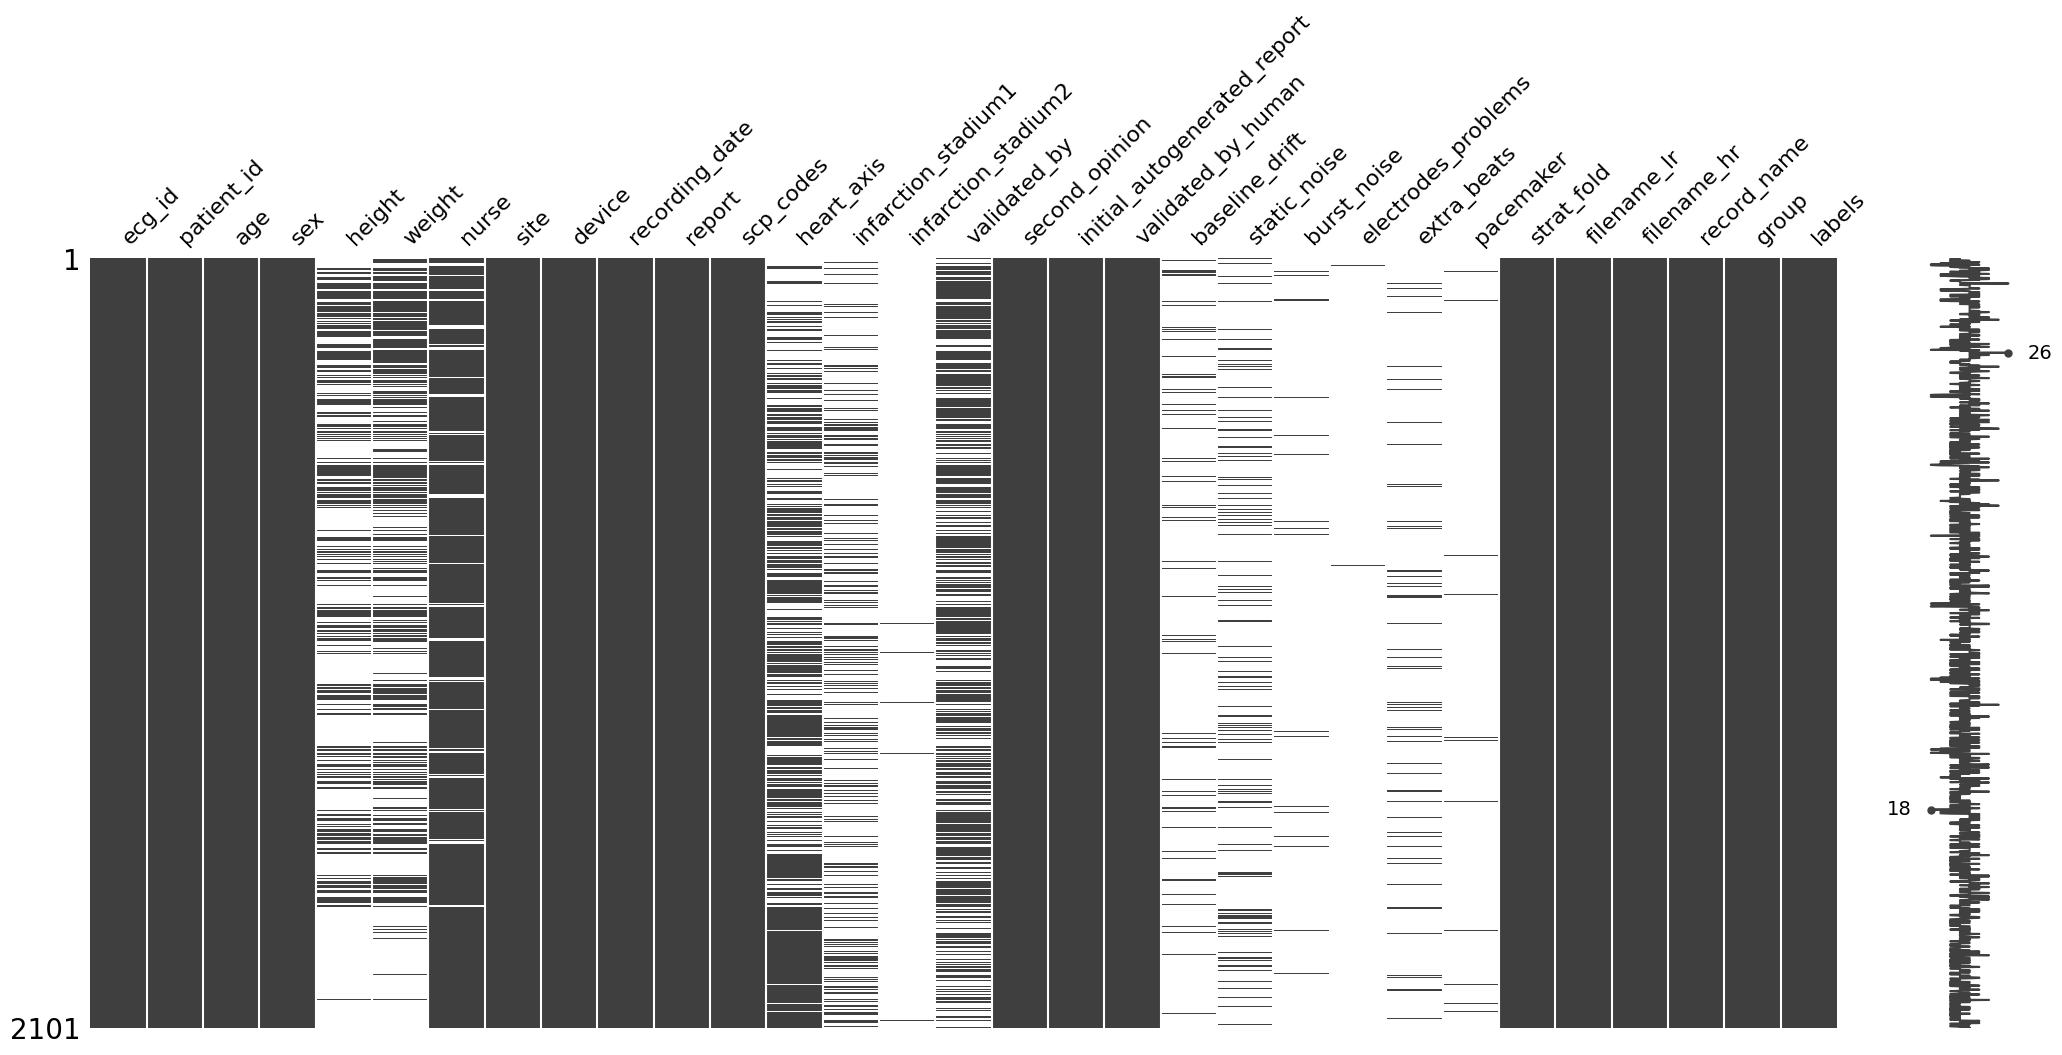

In [ ]:
import missingno as msno

msno.matrix(d.df)
plt.show()

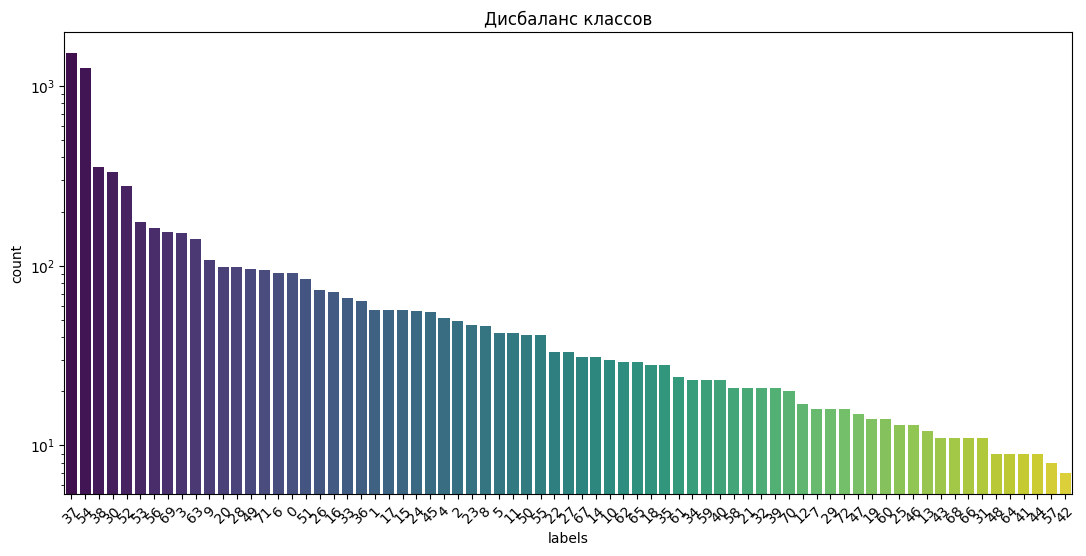

In [ ]:
# визуализация дисбаланса
all_labels = [label for labels in d.df['labels'] for label in labels]
labels_count = Counter(all_labels)
df_labels = pd.DataFrame({'labels': list(labels_count.keys()), 'count': list(labels_count.values())})
plt.figure(figsize=(13, 6))
ax = sns.barplot(data=df_labels, x='labels', y='count', order=[k for k, _ in labels_count.most_common()],  log=True, palette="viridis")
plt.title('Дисбаланс классов')
plt.xticks(rotation=45)
plt.show()

In [ ]:
matrix = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(train_labels, order=2) for combination in row),
    'val' : Counter(str(combination) for row in get_combination_wise_output_matrix(val_labels, order=2) for combination in row)
}).T.fillna(0.0)
matrix

,"(37, 37)","(22, 37)","(22, 22)","(1, 37)","(37, 54)","(1, 1)","(54, 54)","(1, 54)","(16, 16)","(16, 54)",...,"(18, 45)","(45, 70)","(69, 70)","(6, 35)","(0, 42)","(35, 42)","(0, 35)","(3, 42)","(38, 42)","(17, 26)"
train,1200.0,24.0,26.0,34.0,718.0,44.0,981.0,23.0,60.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
val,319.0,6.0,7.0,10.0,192.0,13.0,273.0,10.0,11.0,8.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


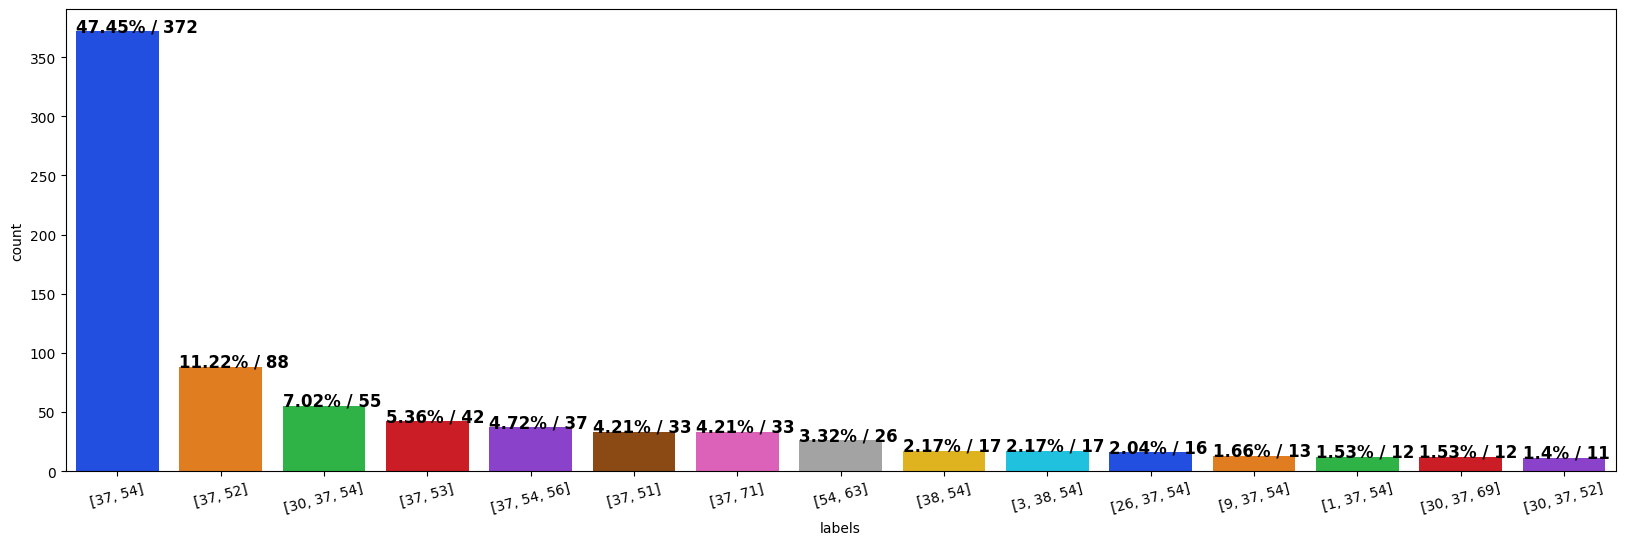

In [ ]:
threshold = 10
df_new = d.df[d.df['labels'].isin(d.df['labels'].value_counts()[d.df['labels'].value_counts() > threshold].index)]

percentages = [count / df_new.shape[0] * 100 for count in df_new['labels'].value_counts()]
fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(
    x=df_new['labels'],
    ax=ax,
    palette="bright",
    order=df_new['labels'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

for percentage, count, p in zip(
    percentages,
    df_new['labels'].value_counts(sort=True).values,
    ax.patches):

    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')


**Характеристики меток**

In [ ]:
def IRLbl(y):
    LABELS = defaultdict(int)
    for sample in y:
        for label in sample:
            LABELS[label] += 1

    max_count = max(LABELS.values())
    for key,value in LABELS.items():
        # print(LABELS[key])
        LABELS[key] = max_count/LABELS[key]

    return LABELS

In [ ]:
def MeanIR(y,ratios=False):
    imb_ratios = IRLbl(y)
    if ratios:
        return (sum(imb_ratios.values())/len(imb_ratios), imb_ratios)
    else:
        return (sum(imb_ratios.values())/len(imb_ratios))

In [ ]:
def CVIR(y):
  mean_ir, ratios = MeanIR(y,ratios=True)
  ratios = np.array(list(ratios.values()))
  var = np.sqrt(sum((abs(ratios - mean_ir)**2))/(len(ratios)-1))
  # var = (sum((abs(ratios - mean_ir)))/(len(ratios)-1))

  cvir = var/mean_ir
  return cvir

In [ ]:
def SCUMBLE(y):
    ratios = IRLbl(y)

    scumbles = []
    for sample in y:
        am = 0
        gm = 1
        for label in sample:
            ratio = ratios[label]
            am += ratio
            gm *= ratio

        n_labels  = len(sample)
        am/=n_labels
        gm = np.power(gm, 1/n_labels)

        scumble = 1-(gm/am)
        scumbles.append(scumble)


    return np.mean(scumbles), scumbles

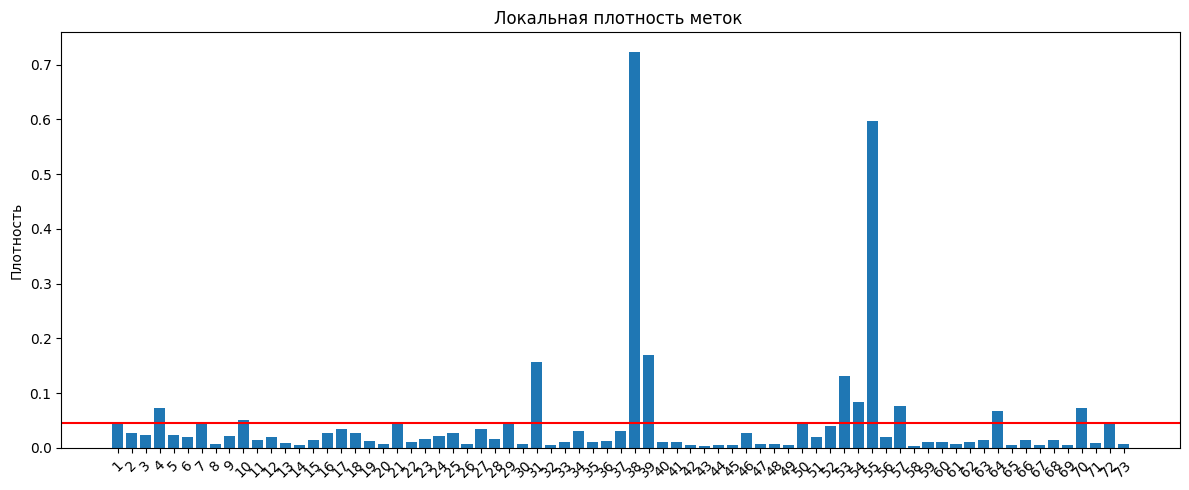

In [ ]:
# локальная плотность меток
def local_label_density(y):

    num_samples, num_labels = y.shape
    local_densities = []

    for label_idx in range(num_labels):
        label_indicator = y[:, label_idx]
        local_density = np.sum(label_indicator) / num_samples
        local_densities.append(local_density)

    return np.array(local_densities)

# глобальная плотность
global_density = np.mean(local_label_density(d.bin_labels))

label_names = [f"{i+1}" for i in range(d.bin_labels.shape[1])]
plt.figure(figsize=(12, 5))
plt.bar(label_names, local_label_density(d.bin_labels))
plt.ylabel("Плотность")
plt.title("Локальная плотность меток ")
plt.xticks(rotation=45)
plt.tight_layout()
plt.axhline(y=global_density, color='red', linestyle='-', label='Глобальная плотность')
plt.show()

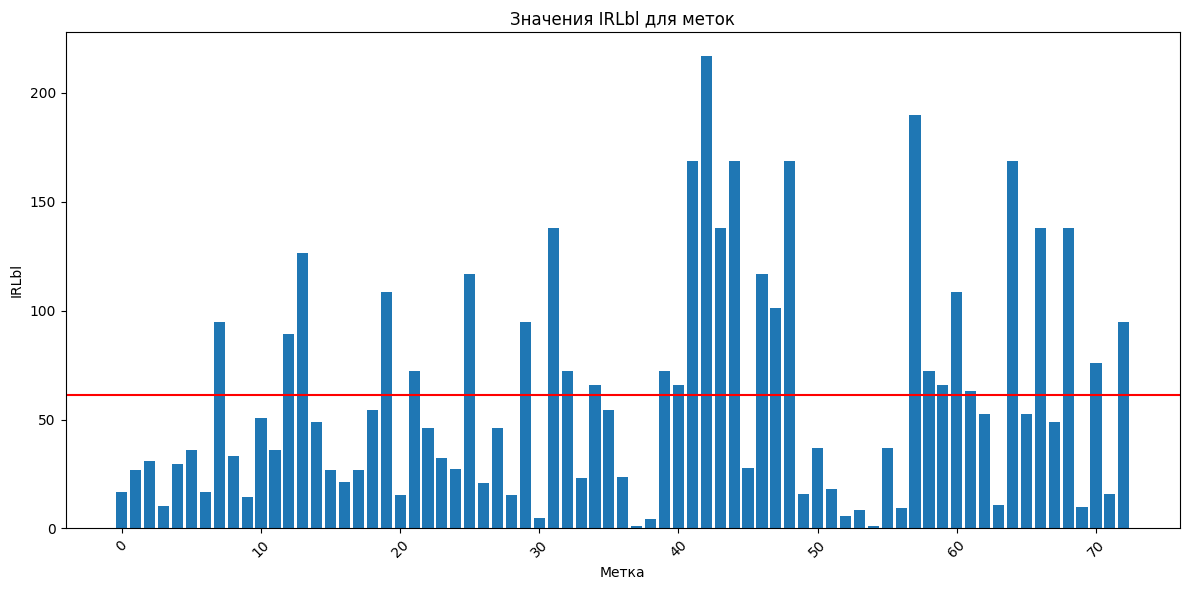

In [ ]:
# визуализация IRLbl
labels = list(IRLbl(d.labels).keys())
values = list(IRLbl(d.labels).values())

plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xlabel("Метка")
plt.ylabel("IRLbl")
plt.title("Значения IRLbl для меток")
plt.xticks(rotation=45)
plt.tight_layout()
plt.axhline(y=MeanIR(d.labels), color='red', linestyle='-', label='MeanIR') # визуализация MeanIR
plt.show()

**Методы балансировки**

In [ ]:
#Создает пакеты с образцами для каждой метки в наборе данных.
def Label_Bags(X,y):
    assert(len(X) == len(y))
    Bags = defaultdict(list)
    for id, labels in enumerate(y):
        for label in labels:
            Bags[label].append([X[id],y[id]])
    return Bags

In [ ]:
def ML_ROS(dataset, p):

    (X,y) = dataset
    X = list(X)
    y = list(y)

    samples_to_clone = len(X)*p/(100)
    mean_ir, imb_ratios = MeanIR(y=y, ratios=True)
    label_bags = Label_Bags(X,y)

    minBag = {}
    for label in label_bags.keys():
        if imb_ratios[label] > mean_ir:
            minBag[label] = label_bags[label]

    while samples_to_clone>0:
        if(minBag):
            for label in list(minBag):
                minBag_i = minBag[label]
                sample = random.sample(minBag_i,1)[0]

                minBag_i.append(sample)
                X.append(sample[0])
                y.append(sample[1])

                mean_ir, imb_ratios = MeanIR(y=y,ratios=True)
                if imb_ratios[label] <= mean_ir:
                    minBag.pop(label)
                    # print(f'label {label} popped')
                samples_to_clone-=1
                # print(f'{len(X)}, {samples_to_clone} mean_ir {mean_ir}')
        else:
            minBag = {}
            for label in label_bags.keys():
                if imb_ratios[label] > mean_ir:
                    minBag[label] = label_bags[label]

            if(minBag is None):
                break
    return X,y

In [ ]:
# mlros = ML_ROS((train_images, train_labels),p= 200)
import pickle
with open("mlros_new.pickle", "rb") as f:
    try:
        mlros = pickle.load(f)
        # print(mlros)
    except EOFError:
        print("Файл пуст или поврежден. Пересохраните данные.")

In [ ]:
mlros_images=np.array(mlros[0])
mlros_images.shape

(4959, 12, 5000)

In [ ]:
mlros_labels=np.array(mlros[1])
mlros_labels.shape

(4959, 73)

In [ ]:
mlros_labels_mlb = d.mlb.inverse_transform(mlros_labels)

In [ ]:
# MLSMOTE
# https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote?scriptVersionId=43649055
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()

    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [ ]:
X_df = pd.DataFrame(train_images.reshape(train_images.shape[0], -1))
y_df = pd.DataFrame(train_labels)

X_sub, y_sub = get_minority_samples(X_df, y_df)
mlsmote_images, mlsmote_labels = MLSMOTE(X_sub, y_sub, 5000, 5)

# with open("mlsmote_new_img.pickle", "rb") as f:
#     try:
#         mlsmote_images = pickle.load(f)
#         print(mlsmote_images)
#     except EOFError:
#         print("Файл пуст или поврежден. Пересохраните данные.")

# with open("mlsmote_new_lab.pickle", "rb") as f:
#     try:
#         mlsmote_labels = pickle.load(f)
#         print(mlsmote_labels)
#     except EOFError:
#         print("Файл пуст или поврежден. Пересохраните данные.")

In [ ]:
mlsmote_images = np.array(mlsmote_images).reshape(-1, 12, 5000)
mlsmote_labels = np.array(mlsmote_labels)

In [ ]:
mlsmote_images.shape

(5000, 12, 5000)

In [ ]:
mlsmote_labels_mlb = d.mlb.inverse_transform(mlsmote_labels)

In [ ]:
def MLSIN(D, p, k=5):
    """
    Аргументы:
        D: Набор данных с многометкой, представленный в виде матрицы (n_samples, n_features).
        p: Коэффициент недовыборки.
        k: Количество ближайших соседей для расчета матрицы C.

    Возвращает:
        D_prime: Новый набор данных, полученный в результате передискретизации.
    """

    n_samples = D.shape[0]
    Num = int(n_samples * p)
    D_prime = D.copy()

    # 1. Найти k ближайших соседей для каждого образца
    knn = NearestNeighbors(n_neighbors=k + 1).fit(D)
    _, knn_indices = knn.kneighbors(D)

    # 2. Рассчитать матрицу C
    C = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if np.array_equal(D[i], D[j]):
                C[i, j] = C[j, i] = 0
            else:
                C[i, j] = C[j, i] = 1 / k * np.sum(D[i] != D[knn_indices[i][1:]])

    # 3. Определить матрицу типов T
    T = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if 0 < C[i, j] < 0.3:
                T[i, j] = T[j, i] = 1  # IC
            elif 0.3 <= C[i, j] < 0.5:
                T[i, j] = T[j, i] = 2  # BD
            elif 0.5 <= C[i, j] < 0.7:
                T[i, j] = T[j, i] = 3  # OB
            elif 0.7 <= C[i, j] < 1:
                T[i, j] = T[j, i] = 4  # OT

    # 4. Рассчитать веса образцов
    w = np.zeros(n_samples)
    for i in range(n_samples):
        w[i] = np.sum(C[i])

    # 5. Генерация новых образцов
    while Num > 0:
        # Выбор базового образца
        ref_idx = np.argmax(w)

        # Выбор соседнего образца
        neighbor_idx = np.argmax(w[knn_indices[ref_idx][1:]])

        # Генерация нового образца
        xg = (D[ref_idx] + D[knn_indices[ref_idx][neighbor_idx]]) / 2

        # Генерация новых меток
        Yg = np.zeros_like(D[ref_idx])
        for j in range(D.shape[1]):
            if T[ref_idx, knn_indices[ref_idx][neighbor_idx]] == 1:  # IC
                Yg[j] = D[ref_idx][j]
            elif T[ref_idx, knn_indices[ref_idx][neighbor_idx]] in (2, 3):  # BD, OB
                Yg[j] = (D[ref_idx][j] + D[knn_indices[ref_idx][neighbor_idx]][j]) / 2
            else:  # OT
                Yg[j] = D[ref_idx][j]

        # Добавление нового образца в D_prime
        D_prime = np.vstack((D_prime, xg))
        Num -= 1

    return D_prime


In [ ]:
# train_data_conc = np.concatenate((train_images.reshape(train_images.shape[0], -1), train_labels), axis=1)

In [ ]:
# mlsin = MLSIN(train_data_conc,0.5)
with open("mlsin_new.pickle", "rb") as f:
    try:
        mlsin = pickle.load(f)
        # print(mlsin)
    except EOFError:
        print("Файл пуст или поврежден. Пересохраните данные.")

In [ ]:
image_size = 60000

images_mlsin = mlsin[:, :image_size]
labels_mlsin = mlsin[:, image_size:]

images_mlsin = images_mlsin.reshape(-1, 12, 5000)

In [ ]:
images_mlsin.shape

(2479, 12, 5000)

In [ ]:
labels_mlsin = labels_mlsin.astype(int)
labels_mlsin_mlb = d.mlb.inverse_transform(labels_mlsin)

In [ ]:
class MLUL:
  def __init__(self, random_state=None):
    self.random_state = random_state
    self.rng = random.Random(random_state) # Создаем генератор случайных чисел

  def fit_resample(self, X, y):
    """
    Выполняет MLUL ресемплинг.

    Args:
      X: Массив признаков (numpy array).
      y: Массив бинарных меток (numpy array).

    Returns:
      Кортеж из resampled X и resampled y.
    """
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
      raise TypeError("X and y must be numpy arrays.")
    if X.shape[0] != y.shape [0] :
      raise ValueError("X and y must have the same number of samples.")

    # Подсчет частоты каждой метки
    label_counts = np.sum(y, axis=0)
    # Целевое количество образцов для каждой метки (можно изменить стратегию)
    target_count = np.min(label_counts)


    resampled_X = []
    resampled_y = []

    for label_index in range(y.shape[1]):
      # Индексы образцов с данной меткой
      indices = np.where(y[:, label_index] == 1)[0]

      # Случайный выбор образцов для данной метки (для балансировки)
      if len(indices) > target_count:
        selected_indices = np.array(self.rng.sample(list(indices), k=target_count)) # Используем self.rng.sample
      else:
        selected_indices = indices

      # Добавление выбранных образцов в результирующий массив
      resampled_X.extend(X[selected_indices])
      resampled_y.extend(y[selected_indices])

    return np.array(resampled_X), np.array(resampled_y)

In [ ]:
mlul = MLUL(random_state=42)
mlul_images, mlul_labels = mlul.fit_resample(train_images, train_labels)
# with open("mlul_images.pickle", "rb") as f:
#     try:
#         mlul_images = pickle.load(f)
#         # print(mlul_images)
#     except EOFError:
#         print("Файл пуст или поврежден. Пересохраните данные.")

# with open("mlul_labels.pickle", "rb") as f:
#     try:
#         mlul_labels = pickle.load(f)
#         # print(mlul_labels)
#     except EOFError:
#         print("Файл пуст или поврежден. Пересохраните данные.")

In [ ]:
mlul_images.shape

(438, 12, 5000)

In [ ]:
mlul_labels.shape

(438, 73)

In [ ]:
mlul_labels_mlb = d.mlb.inverse_transform(mlul_labels)

In [ ]:
unique_train_labels, counts_train_labels = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
print(f"Исходные данные: {dict(zip(unique_train_labels, counts_train_labels))}")

Исходные данные: {0: 77, 1: 44, 2: 34, 3: 101, 4: 27, 5: 24, 6: 46, 7: 7, 8: 23, 9: 60, 10: 17, 11: 21, 13: 7, 14: 14, 15: 31, 16: 39, 17: 24, 18: 12, 19: 4, 20: 34, 21: 8, 22: 20, 23: 16, 24: 18, 25: 4, 26: 31, 27: 15, 28: 37, 29: 5, 30: 134, 31: 4, 32: 11, 33: 14, 34: 6, 35: 9, 36: 22, 37: 582, 38: 26, 39: 3, 41: 1, 45: 2, 46: 1, 49: 2, 52: 4, 53: 5, 54: 20, 56: 1, 58: 2, 63: 2, 64: 2}


In [ ]:
unique_selected_labels, counts_selected_labels = np.unique(np.argmax(mlul_labels, axis=1), return_counts=True)
print(f"После MLUL: {dict(zip(unique_selected_labels, counts_selected_labels))}")

После MLUL: {0: 42, 1: 10, 2: 9, 3: 48, 4: 16, 5: 9, 6: 14, 7: 5, 8: 9, 9: 22, 10: 3, 11: 8, 13: 6, 14: 8, 15: 12, 16: 10, 17: 13, 18: 5, 19: 2, 20: 12, 21: 3, 22: 7, 23: 2, 24: 14, 25: 2, 26: 6, 27: 4, 28: 16, 29: 3, 30: 15, 31: 5, 32: 5, 33: 2, 34: 5, 35: 3, 36: 5, 37: 56, 38: 2, 39: 5, 41: 2, 45: 2, 46: 2, 49: 1, 52: 1, 53: 2, 54: 2, 56: 1, 58: 1, 64: 1}


In [ ]:
# import pickle
# with open("mlul_images.pickle", "wb") as f:
#   pickle.dump(mlul_images, f)
# with open("mlul_labels.pickle", "wb") as f:
#   pickle.dump(mlul_labels, f)

In [ ]:
def REMEDIAL(X, y):

    mean_ir, ratios = MeanIR(y, True)
    updated_X = []
    updated_y = []
    for i in range(len(X)):
        X_i = X[i]
        y_i = y[i]

        # Создание копии данных для сохранения исходных меток
        c_X_i = deepcopy(X_i)
        c_y_i = deepcopy(y_i)

        # Выделение редких (minority) и частых (majority) меток
        minority_labels = [i for i in range(len(c_y_i)) if ratios[i] > 0.05 * mean_ir]
        majority_labels = [i for i in range(len(y_i)) if ratios[i] <= 0.1 * mean_ir]

        # Добавление редких меток в обновленные списки
        if any(minority_labels):
            updated_X.append(c_X_i)
            updated_y.append(c_y_i)

        # Добавление исходных или частых меток в обновленные списки
        if any(majority_labels):
            updated_X.append(X_i)
            updated_y.append(y_i)

    return np.array(updated_X), np.array(updated_y)


In [ ]:
# remedial = REMEDIAL(train_images, train_labels)
with open("remedial.pickle", "rb") as f:
    try:
        remedial = pickle.load(f)
        # print(remedial)
    except EOFError:
        print("Файл пуст или поврежден. Пересохраните данные.")

In [ ]:
remedial_images = remedial[0]

In [ ]:
remedial_labels = remedial[1]

In [ ]:
remedial_labels_mlb = d.mlb.inverse_transform(remedial_labels)

**Сравнение некоторых характеристик**

In [ ]:
irlbl = IRLbl(d.labels)
irlbl_mlros = IRLbl(mlros_labels_mlb)
irlbl_mlsin = IRLbl(labels_mlsin_mlb)
irlbl_mlsmote = IRLbl(mlsmote_labels_mlb)
irlbl_mlul = IRLbl(mlul_labels_mlb)
irlbl_remedial = IRLbl(remedial_labels_mlb)

print(f"irlbl: {irlbl}")
print(f"irlbl_mlros: {irlbl_mlros}")
print(f"irlbl_mlsin: {irlbl_mlsin}")
print(f"irlbl_mlsmote: {irlbl_mlsmote}")
print(f"irlbl_mlul: {irlbl_mlul}")
print(f"irlbl_remedial: {irlbl_remedial}")

irlbl: defaultdict(<class 'int'>, {37: 1.0, 54: 1.211323763955343, 58: 72.33333333333333, 22: 46.03030303030303, 1: 26.649122807017545, 16: 21.3943661971831, 50: 37.048780487804876, 53: 8.630681818181818, 7: 94.9375, 21: 72.33333333333333, 24: 27.125, 69: 9.928104575163399, 38: 4.27887323943662, 52: 5.483754512635379, 6: 16.692307692307693, 20: 15.5, 30: 4.6030303030303035, 63: 10.77304964539007, 4: 29.784313725490197, 67: 49.0, 8: 33.02173913043478, 62: 52.37931034482759, 0: 16.692307692307693, 56: 9.434782608695652, 33: 23.015151515151516, 49: 15.822916666666666, 70: 75.95, 28: 15.5, 17: 26.649122807017545, 9: 14.19626168224299, 36: 23.734375, 5: 36.166666666666664, 26: 20.80821917808219, 15: 26.649122807017545, 34: 66.04347826086956, 51: 18.083333333333332, 55: 37.048780487804876, 3: 10.059602649006623, 45: 27.618181818181817, 13: 126.58333333333333, 48: 168.77777777777777, 65: 52.37931034482759, 10: 50.63333333333333, 14: 49.0, 43: 138.0909090909091, 11: 36.166666666666664, 18: 54.

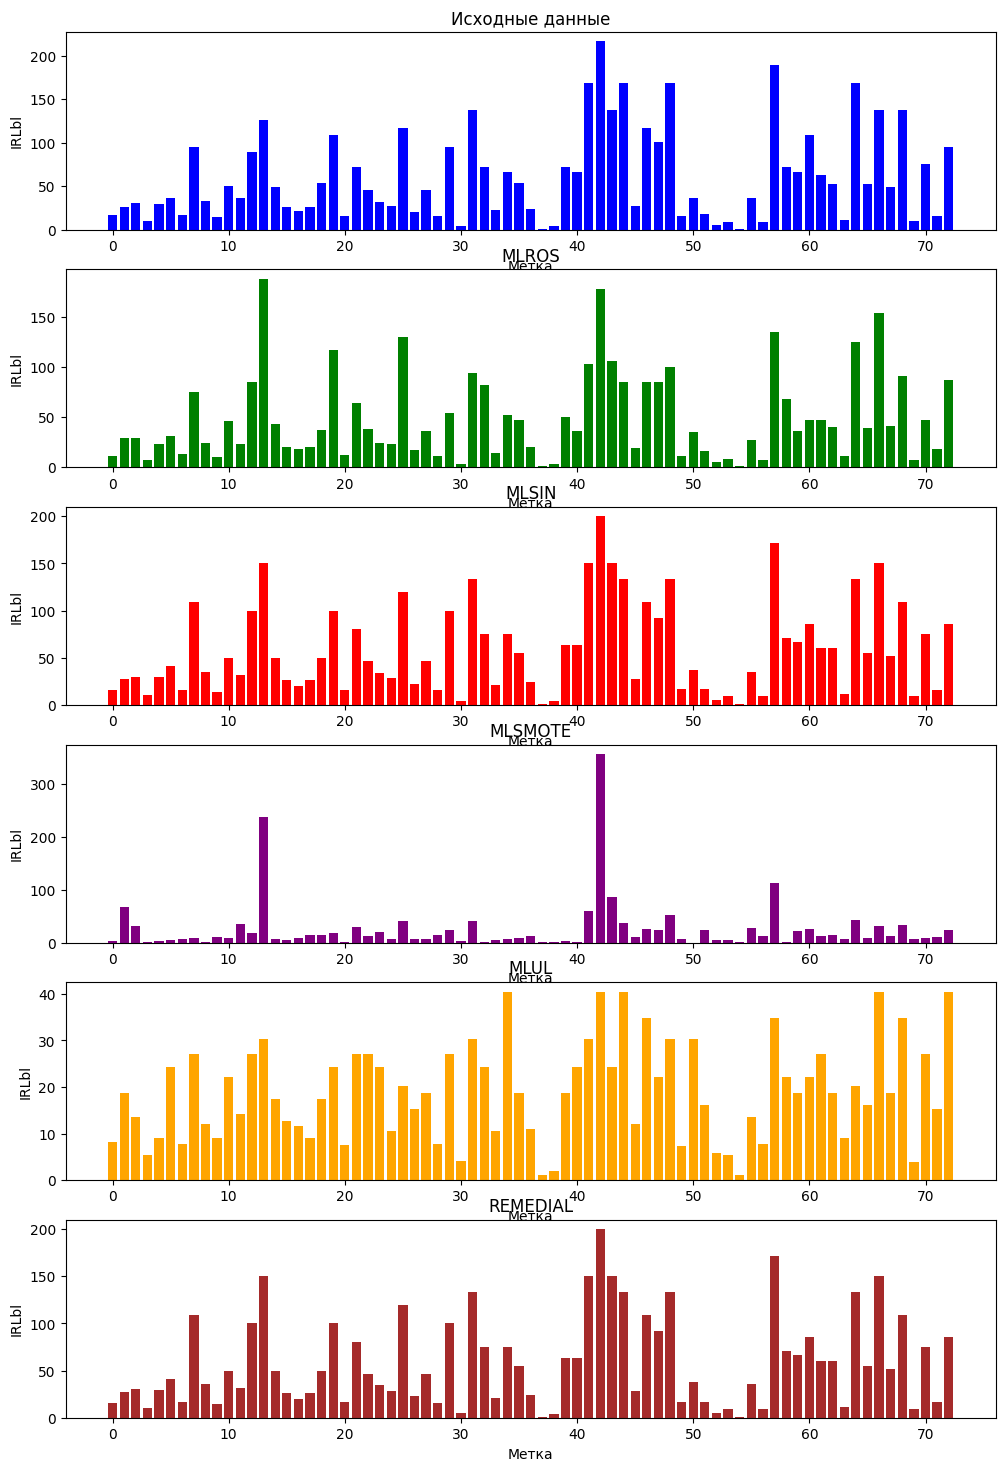

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(12, 18))

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

axes[0].bar(irlbl.keys(), irlbl.values(), color=colors[0])
axes[1].bar(irlbl_mlros.keys(), irlbl_mlros.values(), color=colors[1])
axes[2].bar(irlbl_mlsin.keys(), irlbl_mlsin.values(), color=colors[2])
axes[3].bar(irlbl_mlsmote.keys(), irlbl_mlsmote.values(), color=colors[3])
axes[4].bar(irlbl_mlul.keys(), irlbl_mlul.values(), color=colors[4])
axes[5].bar(irlbl_remedial.keys(), irlbl_remedial.values(), color=colors[5])

for i in range(6):
  axes[i].set_xlabel("Метка")
  axes[i].set_ylabel("IRLbl")

axes[0].set_title("Исходные данные")
axes[1].set_title("MLROS")
axes[2].set_title("MLSIN")
axes[3].set_title("MLSMOTE")
axes[4].set_title("MLUL")
axes[5].set_title("REMEDIAL")

plt.show()


TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

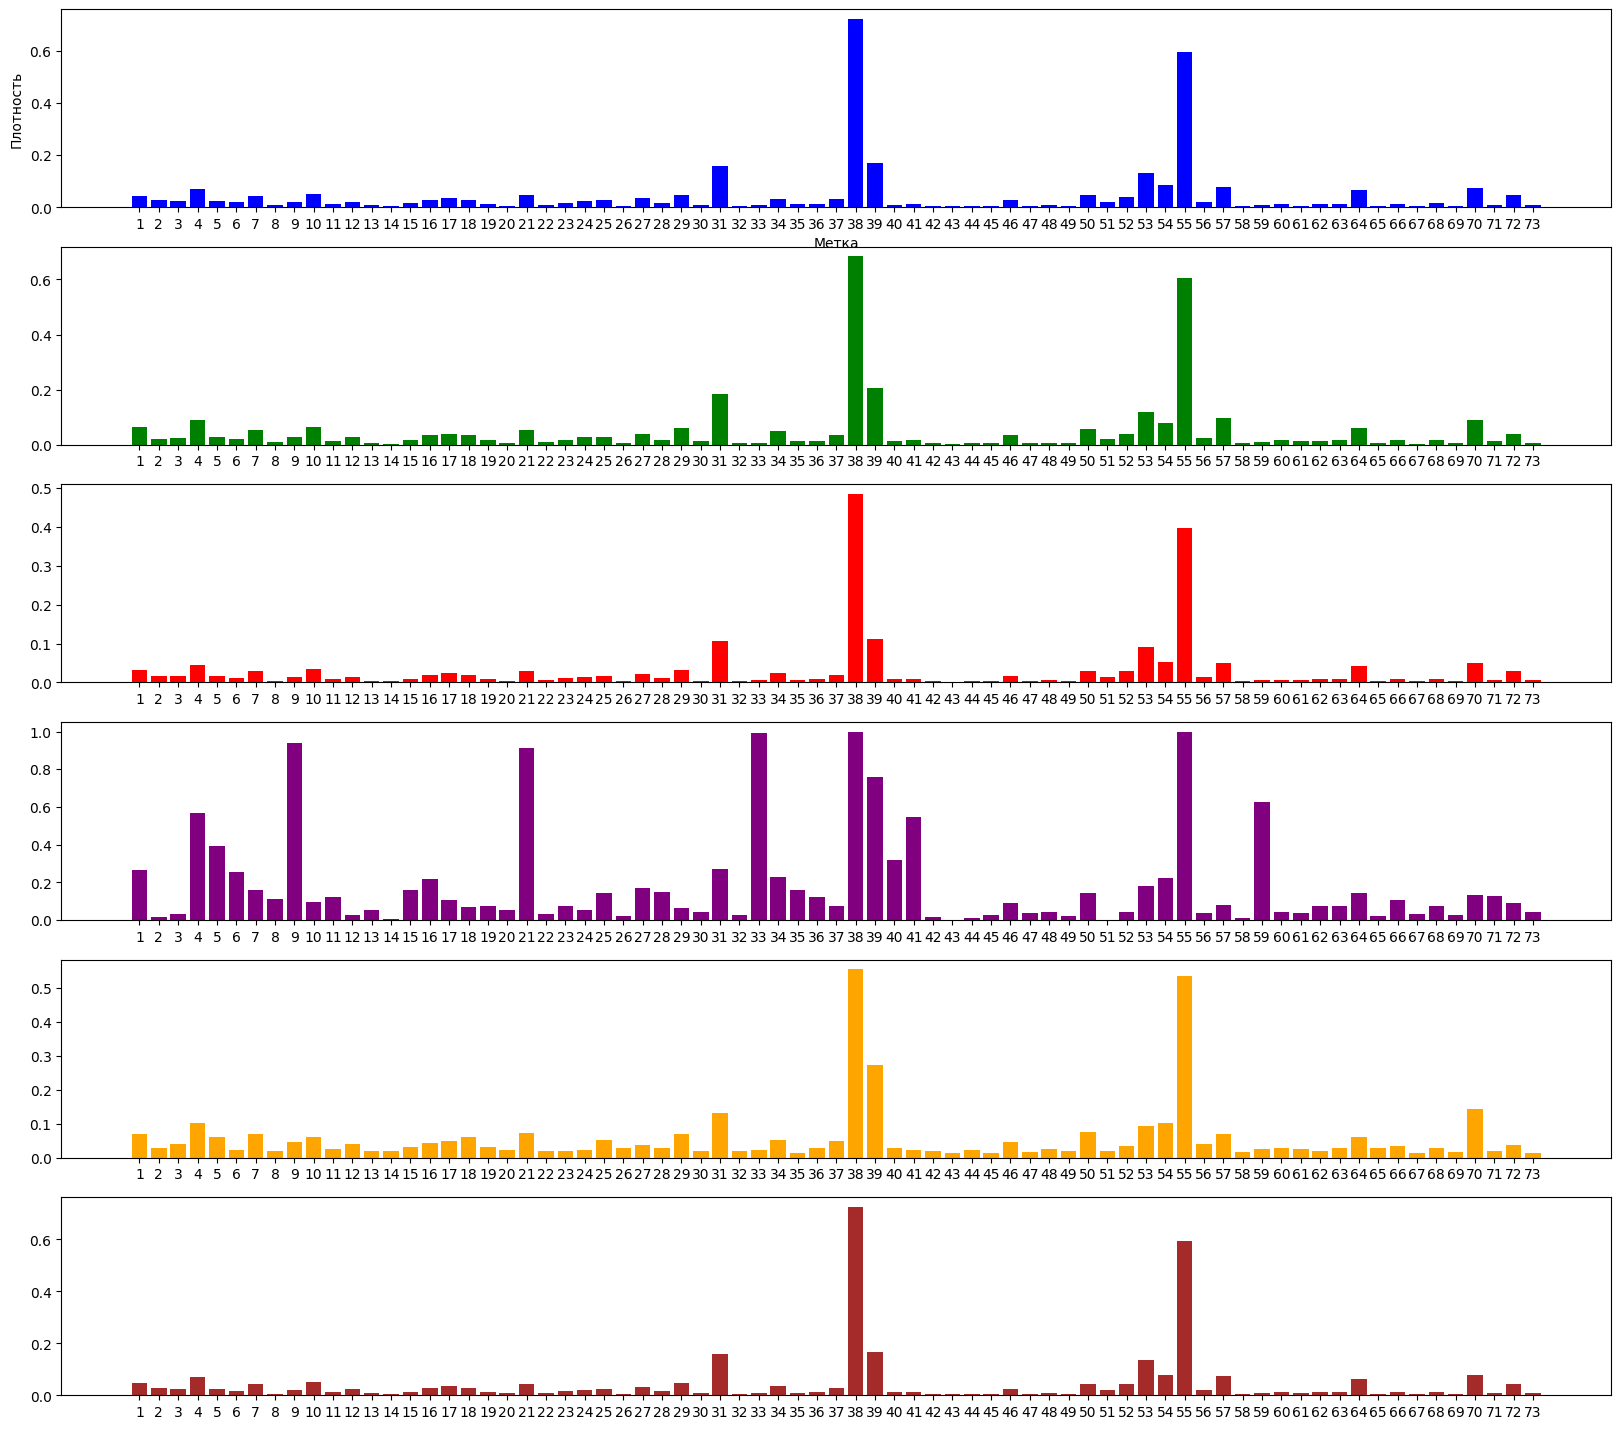

In [ ]:
# локальная плотность
local_density = local_label_density(d.bin_labels)
local_density_mlros = local_label_density(mlros_labels)
local_density_mlsin = local_label_density(labels_mlsin)
local_density_mlsmote = local_label_density(mlsmote_labels)
local_density_mlul = local_label_density(mlul_labels)
local_density_remedial = local_label_density(remedial_labels)

# глобальная плотность
global_density = np.mean(local_density)
global_density_mlros = np.mean(local_density_mlros)
global_density_mlsin = np.mean(local_density_mlsin)
global_density_mlsmote = np.mean(local_density_mlsmote)
global_density_mlul = np.mean(local_density_mlul)
global_density_remedial = np.mean(local_density_remedial)

fig, axes = plt.subplots(6, 1, figsize=(20, 18))

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

axes[0].bar(label_names, local_density, color=colors[0])
axes[1].bar(label_names, local_density_mlros, color=colors[1])
axes[2].bar(label_names, local_density_mlsin, color=colors[2])
axes[3].bar(label_names, local_density_mlsmote, color=colors[3])
axes[4].bar(label_names, local_density_mlul, color=colors[4])
axes[5].bar(label_names, local_density_remedial, color=colors[5])


for i in range(6):
  axes[i].set_xlabel("Метка")
  axes[i].set_ylabel("Плотность")
  axes[i].set_xticks(rotation=45)
  axes[i].tight_layout()

  if i == 0:
    axes[i].axhline(y=global_density, color='red', linestyle='-', label='Глобальная плотность')
  elif i == 1:
    axes[i].axhline(y=global_density_mlros, color='red', linestyle='-', label='Глобальная плотность')
  elif i == 2:
    axes[i].axhline(y=global_density_mlsin, color='red', linestyle='-', label='Глобальная плотность')
  elif i == 3:
    axes[i].axhline(y=global_density_mlsmote, color='red', linestyle='-', label='Глобальная плотность')
  elif i == 4:
    axes[i].axhline(y=global_density_mlul, color='red', linestyle='-', label='Глобальная плотность')
  else:
    axes[i].axhline(y=global_density_remedial, color='red', linestyle='-', label='Глобальная плотность')

axes[0].set_title("Исходные данные")
axes[1].set_title("MLROS")
axes[2].set_title("MLSIN")
axes[3].set_title("MLSMOTE")
axes[4].set_title("MLUL")
axes[5].set_title("REMEDIAL")

plt.show()

**MultiLabel классификация**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Стандартизация данных
stand_scaler = StandardScaler()
train_images_scaled = stand_scaler.fit_transform(train_images.reshape(train_images.shape[0], -1))
val_images_scaled = stand_scaler.transform(val_images.reshape(val_images.shape[0], -1))

# для mlul
# mlul_scaler = StandardScaler()
# mlul_images_sc = mlul_scaler.fit_transform(mlul_images.reshape(mlul_images.shape[0], -1))
# val_images_sc_mlul = mlul_scaler.transform(val_images.reshape(val_images.shape[0], -1))

# для mlsmote
# mlsmote_scaler = StandardScaler()
# mlsmote_images_sc = mlsmote_scaler.fit_transform(mlsmote_images.reshape(mlsmote_images.shape[0], -1))
# val_images_sc_mlsmote = mlsmote_scaler.transform(val_images.reshape(val_images.shape[0], -1))

# для mlros
# mlros_scaler = StandardScaler()
# mlros_images_sc = mlros_scaler.fit_transform(mlros_images.reshape(mlros_images.shape[0], -1))
# val_images_sc_mlros = mlros_scaler.transform(val_images.reshape(val_images.shape[0], -1))

# mlsin
# mlsin_scaler = StandardScaler()
# mlsin_images_sc = mlsin_scaler.fit_transform(images_mlsin.reshape(images_mlsin.shape[0], -1))
# val_images_sc_mlsin = mlsin_scaler.transform(val_images.reshape(val_images.shape[0], -1))

# remedial
# rem_scaler = StandardScaler()
# rem_images_sc = rem_scaler.fit_transform(remedial_images.reshape(remedial_images.shape[0], -1))
# val_images_sc_rem = rem_scaler.transform(val_images.reshape(val_images.shape[0], -1))


In [ ]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
classifier = LabelPowerset(
    classifier = RandomForestClassifier(max_depth=5, class_weight='balanced' ),
    require_dense = [False, True]
)

start=time.time()
classifier.fit(train_images_scaled, train_labels)
predictions = classifier.predict(val_images_scaled)

In [ ]:
macro_f1 = f1_score(val_labels, predictions, average='macro')
macro_f1
# 0.03997605027472617 исходные данные
# 0.04214617704648048 mlul
# 0.05810908617357911 mlsmote
# 0.03864586792784668 mlros
# 0.03616505130798915 mlsin
# 0.038642565434460346 remedial

In [ ]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=10)
classifier.fit(train_images_scaled, train_labels)
predictions = classifier.predict(val_images_scaled)

# macro_f1
# 0.03416240057274242 исходные данные
# 0.04626967734917156 remedial
# 0.052985158707041125 mlros
# 0.06750986170360854 mlsmote

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

clf = MultiOutputClassifier(LogisticRegression()).fit(train_images_scaled, train_labels)
predictions = clf.predict(val_images_scaled)

# macro_f1
# 0.05368495200867725 исходные данные
# 0.06620011822339446 remedial
# 0.07004361738096347 mlros


In [ ]:
from sklearn.multioutput import ClassifierChain

base_lr = LogisticRegression(solver='lbfgs', random_state=0)
chain = ClassifierChain(base_lr, order='random', random_state=0)
predictions = chain.fit(train_images_scaled, train_labels).predict(val_images_scaled)

# 0.05628993266864999 исходные данные
# 0.0686400703363261 mlros

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.multioutput import MultiOutputClassifier

svm = LinearSVC(random_state=42)
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)
multilabel_classifier = multilabel_classifier.fit(train_images_scaled, train_labels)
y_test_pred = multilabel_classifier.predict(val_images_scaled)
matrices = multilabel_confusion_matrix(val_labels, y_test_pred)
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(val_labels)).plot()
plt.title('Confusion Matrix for label 1 (type)')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(val_labels)).plot()
plt.title('Confusion Matrix for label 2 (color)')
plt.show()

**1D** **Convolution**

In [ ]:
# Стандартизация данных
stand_scaler = StandardScaler()
train_images_scaled = stand_scaler.fit_transform(train_images.reshape(train_images.shape[0], -1))
val_images_scaled = stand_scaler.transform(val_images.reshape(val_images.shape[0], -1))

In [ ]:
# метаданные
mdata =pd.DataFrame(index=d.df.index)

mdata['age'] = d.df.age
mdata.age.fillna(0, inplace=True)

mdata['sex'] = d.df.sex.astype(float)
mdata.sex.fillna(0, inplace=True)

mdata['height'] = d.df.height
mdata.loc[mdata.height < 50, 'height'] = np.nan
mdata.height.fillna(0, inplace=True)

mdata['weight'] = d.df.weight
mdata.weight.fillna(0, inplace=True)

mdata['infarction_stadium1'] = d.df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

mdata['infarction_stadium2'] = d.df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

mdata['pacemaker'] = (d.df.pacemaker == 'ja, pacemaker').astype(float)

train_mdata = mdata[d.df.strat_fold <= 8]
val_mdata = mdata[d.df.strat_fold.isin(range(9,11))]

In [ ]:
# стандартизация метаданных
mdata_scaler = StandardScaler()
mdata_scaler.fit(train_mdata)

train_mdata = pd.DataFrame(mdata_scaler.transform(train_mdata), columns=train_mdata.columns)
val_mdata = pd.DataFrame(mdata_scaler.transform(val_mdata), columns=val_mdata.columns)

In [ ]:
# прогноз по метаданным
def create_meta_model(meta_data, *, units=32, dropouts=0.3):

    meta_data = tf.keras.layers.Dense(units, activation='relu', name='meta_data_dense_1')(meta_data)
    meta_data = tf.keras.layers.Dropout(dropouts, name='meta_data_drop_1')(meta_data)
    meta_data = tf.keras.layers.Dense(units, activation='relu', name='meta_data_dense_2')(meta_data)
    meta_data = tf.keras.layers.Dropout(dropouts, name='meta_data_drop_2')(meta_data)

    return meta_data

In [ ]:
def create_model01(meta_data_shape, labels_shape):
    meta_data_inputs = tf.keras.Input(meta_data_shape[1:], name='meta_data_inputs')

    meta_data = create_meta_model(meta_data_inputs)
    meta_data = tf.keras.layers.Dense(64, activation='relu', name='labels_dense_1')(meta_data)
    meta_data = tf.keras.layers.Dense(64, activation='relu', name='labels_dense_2')(meta_data)
    meta_data = tf.keras.layers.Dropout(0.5, name='labels_drop_1')(meta_data)
    outputs = tf.keras.layers.Dense(labels_shape[-1], activation='sigmoid', name='labels_outputs')(meta_data)

    model = tf.keras.Model(inputs=meta_data_inputs, outputs=outputs, name='model01')
    return model

In [ ]:
model01 = create_model01(train_mdata.shape, train_labels.shape)
model01.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy', 'Precision', 'Recall'])
model01.summary()

Model: "model01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ meta_data_inputs (InputLayer)        │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ meta_data_dense_1 (Dense)            │ (None, 32)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ meta_data_drop_1 (Dropout)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ meta_data_dense_2 (Dense)            │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ meta_data_drop_2 (Dropout)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ labels_dense_1 (Dense)               │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ labels_dense_2 (Dense)               │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ labels_drop_1 (Dropout)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ labels_outputs (Dense)               │ (None, 73)                  │           4,745 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,329 (48.16 KB)

 Trainable params: 12,329 (48.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
MODEL_CHECKPOINT = '/kaggle/working/model/model01.keras'

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model01.fit(train_mdata, train_labels, epochs=15, batch_size=32, callbacks=callbacks_list)

model01 = tf.keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.0580 - Recall: 0.4203 - binary_accuracy: 0.6456 - categorical_accuracy: 0.0182 - loss: 0.6341
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.4934 - Recall: 0.2879 - binary_accuracy: 0.9546 - categorical_accuracy: 0.1943 - loss: 0.1941
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6550 - Recall: 0.3253 - binary_accuracy: 0.9615 - categorical_accuracy: 0.2339 - loss: 0.1604
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6390 - Recall: 0.3188 - binary_accuracy: 0.9609 - categorical_accuracy: 0.2490 - loss: 0.1550
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6725 - Recall: 0.3304 - binary_accuracy: 0.9624 - categorical_accuracy: 0.2977 - loss: 0.1451
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6761 - Recall: 0.3493 - binary_accuracy: 0.9632 - categorical_accuracy: 0.2764 - loss: 0.1408
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

ValueError: File not found: filepath=/kaggle/working/model/model01.keras. Please ensure the file is an accessible `.keras` zip file.

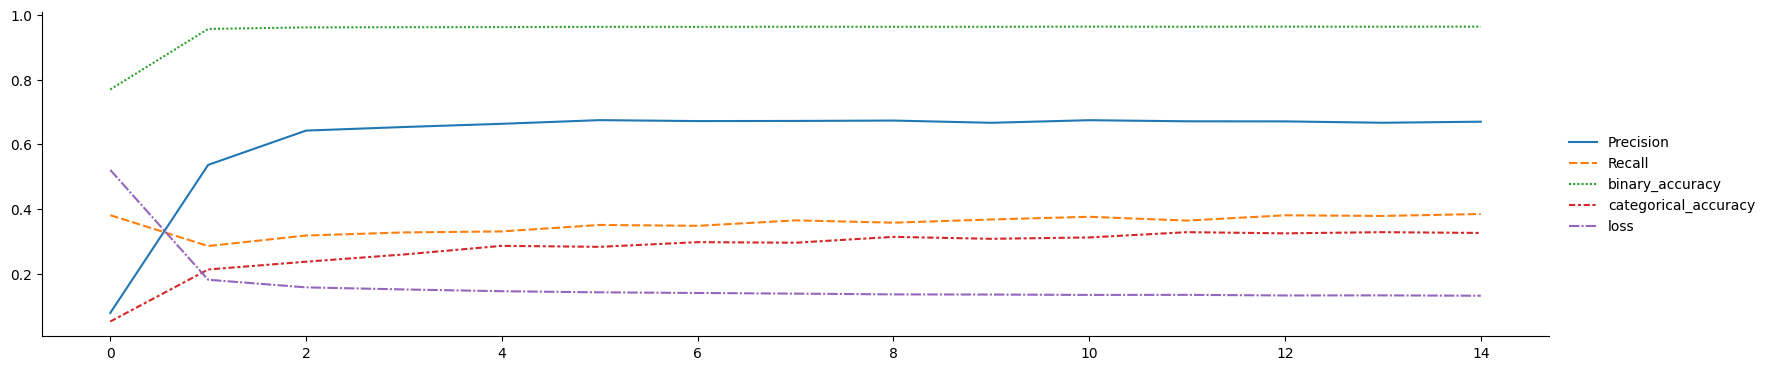

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

In [ ]:
model01.evaluate(val_mdata, val_labels)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6915 - Recall: 0.4192 - binary_accuracy: 0.9663 - categorical_accuracy: 0.3616 - loss: 0.1211  


[0.1257367879152298,
 0.9642245173454285,
 0.3772321343421936,
 0.6697247624397278,
 0.3983629047870636]

In [ ]:
# модель для кривых ЭКГ
def create_images_model(meta_data, *, filters=(32, 64, 128), kernel_size=(5, 3, 3), strides=(1, 1, 1)):

    f1, f2, f3 = filters
    k1, k2, k3 = kernel_size
    s1, s2, s3 = strides

    meta_data = tf.keras.layers.Conv1D(f1, k1, strides=s1, padding='same', name='images_conv_1')(meta_data)
    meta_data = tf.keras.layers.BatchNormalization(name='images_norm_1')(meta_data)
    meta_data = tf.keras.layers.ReLU(name='images_relu_1')(meta_data)

    meta_data = tf.keras.layers.MaxPool1D(2, name='images_pool_1')(meta_data)

    meta_data = tf.keras.layers.Conv1D(f2, k2, strides=s2, padding='same', name='images_conv_2')(meta_data)
    meta_data = tf.keras.layers.BatchNormalization(name='images_norm_2')(meta_data)
    meta_data = tf.keras.layers.ReLU(name='images_relu_2')(meta_data)

    meta_data = tf.keras.layers.MaxPool1D(2, name='images_pool_2')(meta_data)

    meta_data = tf.keras.layers.Conv1D(f3, k3, strides=s3, padding='same', name='images_conv_3')(meta_data)
    meta_data = tf.keras.layers.BatchNormalization(name='images_norm_3')(meta_data)
    meta_data = tf.keras.layers.ReLU(name='images_relu_3')(meta_data)

    meta_data = tf.keras.layers.GlobalAveragePooling1D(name='images_aver')(meta_data)
    meta_data = tf.keras.layers.Dropout(0.5, name='images_drop')(meta_data)

    return meta_data

In [ ]:
# 1D Convolution модель для кривых ЭКГ, улучшенная моделью для метаданных
def create_model02(meta_data_shape, images_shape, labels_shape):
    meta_data_inputs = tf.keras.Input(meta_data_shape[1:], name='meta_data_inputs')
    images_inputs = tf.keras.Input(images_shape[1:], name='images_inputs')

    meta_data = tf.keras.layers.Concatenate(name='labels_concat')([create_meta_model(meta_data_inputs), create_images_model(images_inputs, filters=(64, 128, 256), kernel_size=(7, 3, 3))])
    meta_data = tf.keras.layers.Dense(64, activation='relu', name='labels_dense_1')(meta_data)
    meta_data = tf.keras.layers.Dense(64, activation='relu', name='labels_dense_2')(meta_data)
    meta_data = tf.keras.layers.Dropout(0.5, name='labels_drop_1')(meta_data)
    outputs = tf.keras.layers.Dense(labels_shape[-1], activation='sigmoid', name='labels_outputs')(meta_data)

    model = tf.keras.Model(inputs=[meta_data_inputs, images_inputs], outputs=outputs, name='model02')
    return model

In [ ]:
model02 = create_model02(train_mdata.shape, train_images.shape, train_labels.shape)
model02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model02.summary()

Model: "model02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images_inputs             │ (None, 12, 5000)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_conv_1 (Conv1D)    │ (None, 12, 64)         │      2,240,064 │ images_inputs[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_norm_1             │ (None, 12, 64)         │            256 │ images_conv_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_relu_1 (ReLU)      │ (None, 12, 64)         │              0 │ images_norm_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_pool_1             │ (None, 6, 64)          │              0 │ images_relu_1[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_conv_2 (Conv1D)    │ (None, 6, 128)         │         24,704 │ images_pool_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_norm_2             │ (None, 6, 128)         │            512 │ images_conv_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_relu_2 (ReLU)      │ (None, 6, 128)         │              0 │ images_norm_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_pool_2             │ (None, 3, 128)         │              0 │ images_relu_2[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_inputs          │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_conv_3 (Conv1D)    │ (None, 3, 256)         │         98,560 │ images_pool_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_dense_1 (Dense) │ (None, 32)             │            256 │ meta_data_inputs[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_norm_3             │ (None, 3, 256)         │          1,024 │ images_conv_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_drop_1          │ (None, 32)             │              0 │ meta_data_dense_1[0][… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_relu_3 (ReLU)      │ (None, 3, 256)         │              0 │ images_norm_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_dense_2 (De

 Total params: 2,393,833 (9.13 MB)

 Trainable params: 2,392,937 (9.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
MODEL_CHECKPOINT = '/kaggle/working/model/model02.keras'

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model02.fit([train_mdata, train_images], train_labels, epochs=100, batch_size=32, callbacks=callbacks_list)

model02 = tf.keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - binary_accuracy: 0.7176 - loss: 0.5313
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - binary_accuracy: 0.9505 - loss: 0.1811
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - binary_accuracy: 0.9611 - loss: 0.1492
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - binary_accuracy: 0.9599 - loss: 0.1475
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - binary_accuracy: 0.9624 - loss: 0.1368
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - binary_accuracy: 0.9632 - loss: 0.1312
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - binary_accuracy: 0.9637 - loss: 0.1282
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - binary_accuracy: 0.9653 - loss: 0.1218
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - binary_accuracy: 0.9643 - loss: 0.1217
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - binary_accuracy: 0.9659 - loss: 0.1166
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step

ValueError: File not found: filepath=/kaggle/working/model/model02.keras. Please ensure the file is an accessible `.keras` zip file.

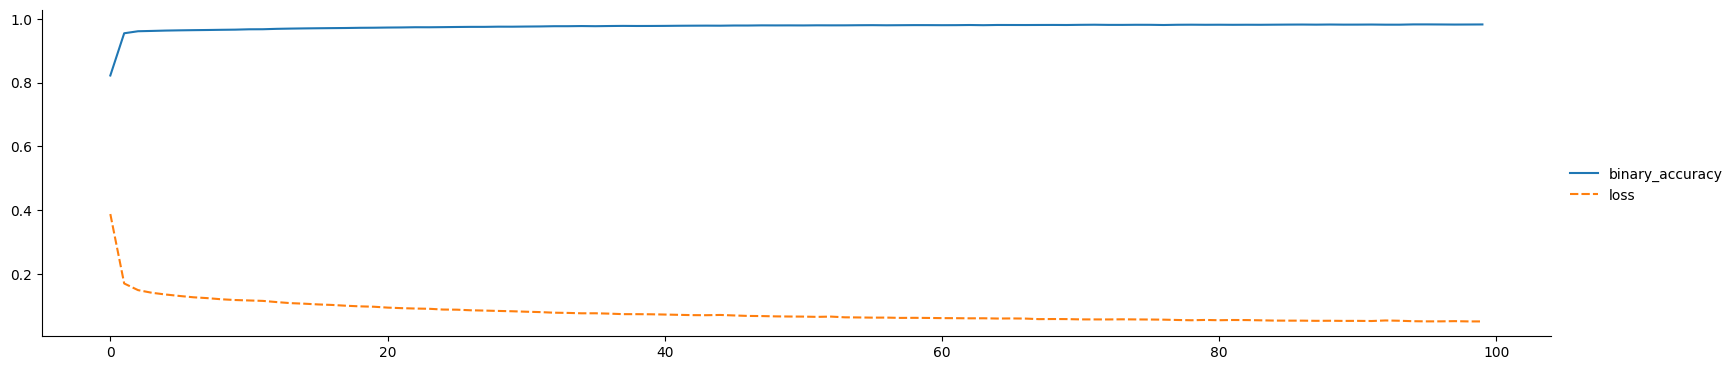

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

In [ ]:
model02.evaluate([val_mdata, val_images], val_labels)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - binary_accuracy: 0.9615 - loss: 0.2885


[0.30437225103378296, 0.9595462679862976]

In [ ]:
# аугментация, чтобы попытаться улучшить результаты
# скользящее окно
def sliding_window(x, size, shift):
    if 0 < size <= x.shape[0]:
        shift = np.random.randint(0, x.shape[0] - size) if shift < 0 else min(shift, x.shape[0] - size)
        return x[shift:shift + size, :]
    elif size > x.shape[0]:
        pad_width = size - x.shape[0]
        x = np.pad(x, ((0, pad_width), (0, 0)), mode='constant')
        return x
    else:
        return x

# добавление шума
class AugmentedDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, x, y, z, batch_size=32, window_size=0, window_shift=0, sigma=0.0, **kwargs):
        super(AugmentedDataGenerator, self).__init__(**kwargs)
        self.x = np.array(x) # Ensure x is a NumPy array
        self.y = np.array(y) # Ensure y is a NumPy array
        self.z = np.array(z) # Ensure z is a NumPy array
        self.batch_size = batch_size
        self.window_size = window_size
        self.window_shift = window_shift
        self.sigma = sigma

    @property
    def x_shape(self):
        return (self.batch_size, ) + self.x.shape[1:]

    @property
    def y_shape(self):
        return (self.batch_size, self.window_size if self.window_size > 0 else self.y.shape[1], ) + self.y.shape[2:]

    @property
    def z_shape(self):
        return (self.batch_size, ) + self.z.shape[1:]

    def __len__(self):
        return math.ceil(len(self.y) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = np.array([sliding_window(r, self.window_size, self.window_shift) for r in self.y[idx * self.batch_size:(idx + 1) * self.batch_size]])
        batch_z = self.z[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.sigma > 0:
            batch_y += np.random.normal(loc=0.0, scale=self.sigma, size=batch_y.shape)

        return (batch_x, batch_y), batch_z

In [ ]:
train_gen = AugmentedDataGenerator(train_mdata, train_images, train_labels, window_size=800, window_shift=-1, sigma=0.05)
valid_gen = AugmentedDataGenerator(val_mdata, val_images, val_labels, window_size=800)

In [ ]:
(x, y), z = train_gen[0]

In [ ]:
model03 = create_model02(train_gen.x_shape, train_gen.y_shape, train_gen.z_shape)
model03.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model03.summary()

Model: "model02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images_inputs             │ (None, 800, 5000)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_conv_1 (Conv1D)    │ (None, 800, 64)        │      2,240,064 │ images_inputs[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_norm_1             │ (None, 800, 64)        │            256 │ images_conv_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_relu_1 (ReLU)      │ (None, 800, 64)        │              0 │ images_norm_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_pool_1             │ (None, 400, 64)        │              0 │ images_relu_1[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_conv_2 (Conv1D)    │ (None, 400, 128)       │         24,704 │ images_pool_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_norm_2             │ (None, 400, 128)       │            512 │ images_conv_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_relu_2 (ReLU)      │ (None, 400, 128)       │              0 │ images_norm_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_pool_2             │ (None, 200, 128)       │              0 │ images_relu_2[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_inputs          │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_conv_3 (Conv1D)    │ (None, 200, 256)       │         98,560 │ images_pool_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_dense_1 (Dense) │ (None, 32)             │            256 │ meta_data_inputs[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_norm_3             │ (None, 200, 256)       │          1,024 │ images_conv_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_drop_1          │ (None, 32)             │              0 │ meta_data_dense_1[0][… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ images_relu_3 (ReLU)      │ (None, 200, 256)       │              0 │ images_norm_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_data_dense_2 (De

 Total params: 2,393,833 (9.13 MB)

 Trainable params: 2,392,937 (9.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
import math
MODEL_CHECKPOINT = '/kaggle/working/model/model03.keras'

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model03.fit(train_gen, epochs=5, batch_size=32, callbacks=callbacks_list)

model03 = tf.keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 662s 12s/step - Precision: 0.0792 - Recall: 0.4531 - binary_accuracy: 0.7204 - loss: 0.5381
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 667s 11s/step - Precision: 0.4506 - Recall: 0.3092 - binary_accuracy: 0.9522 - loss: 0.1812
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 687s 12s/step - Precision: 0.6144 - Recall: 0.3232 - binary_accuracy: 0.9602 - loss: 0.1525
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 686s 12s/step - Precision: 0.6443 - Recall: 0.3284 - binary_accuracy: 0.9620 - loss: 0.1424
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 653s 12s/step - Precision: 0.6636 - Recall: 0.3484 - binary_accuracy: 0.9630 - loss: 0.1397


ValueError: File not found: filepath=/kaggle/working/model/model03.keras. Please ensure the file is an accessible `.keras` zip file.

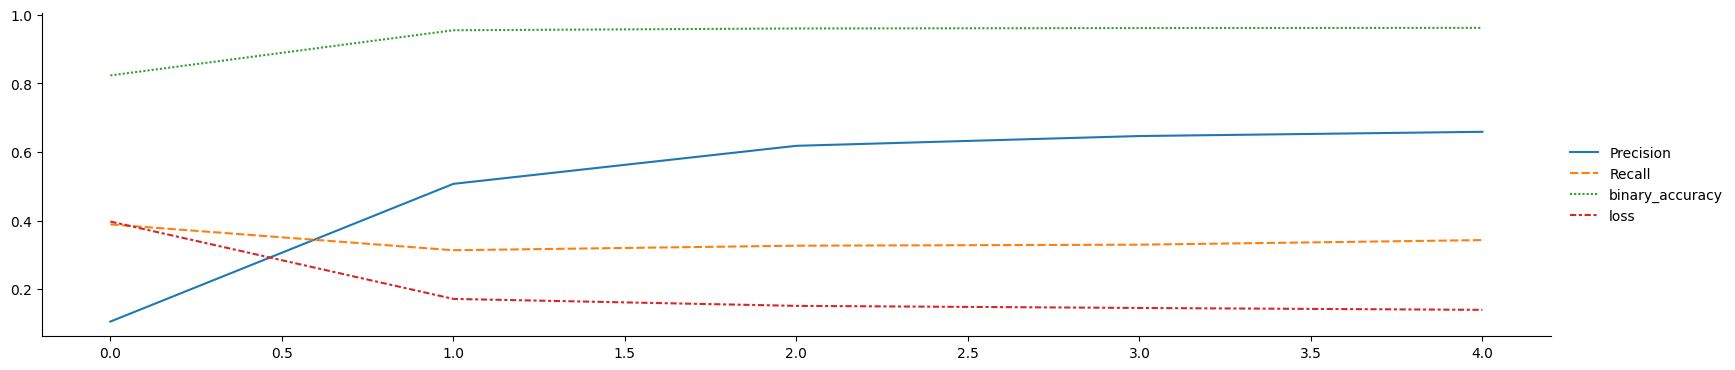

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()


In [ ]:
model03.evaluate(valid_gen)

14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - Precision: 0.6782 - Recall: 0.4237 - binary_accuracy: 0.9659 - loss: 0.1198


[0.12473748624324799,
 0.9639800190925598,
 0.6607142686843872,
 0.4038199186325073]